## Software setup

In [1]:
import sys
import glob
import os
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Add skyllh and i3skyllh projects to the PYTHONPATH
sys.path.insert(0, '/data/user/liruohan/software/skyllh')
sys.path.insert(0, '/data/user/liruohan/software/i3skyllh')
#sys.path.insert(0, '/home/liruohan/.local/lib/python3.7/site-packages')
#sys.path.insert(0, '/home/cbellenghi/.pyenv/versions/3.8.1/lib/python3.8/site-packages')

# Add missing python packages from cvmfs
#sys.path.insert(0, '/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages')
extra_path = "/cvmfs/icecube.opensciencegrid.org/users/tkontrimas/software/pip/python3.11/site-packages" # whatever individual directory it is
if extra_path not in sys.path:
    sys.path.append(extra_path)

In [2]:
from skyllh.core.utils.analysis import calculate_critical_ts_from_gamma

## Create `datasets` object

In [3]:
import numpy as np

In [4]:
bkg_dir='/data/user/liruohan/dm_model_stacking/trials/1TeV/bkg/'
bkg_trials = np.concatenate([np.load(f) for f in glob.glob(os.path.join(bkg_dir, '*.npy'))])

In [5]:
from scipy.stats import norm
#sensitivity
bkg_p_sens = 0.5
sig_p_sens = 0.9
#3 sigma dp
bkg_p_3dp = norm.sf(3,0,1)
sig_p_3dp = 0.5
# 5 sigma dp
bkg_p_5dp = norm.sf(5,0,1)
sig_p_5dp = 0.5

In [6]:
ts_critical_3dp = calculate_critical_ts_from_gamma(bkg_trials['ts'], bkg_p_3dp)
ts_critical_5dp = calculate_critical_ts_from_gamma(bkg_trials['ts'], bkg_p_5dp)

In [7]:
n_max=300
# if energy == 10000:
#     n_max = 80
# if (energy == 1000 or 100):
#     n_max = 300
number_of_signals = np.linspace(1, n_max, n_max)
sig_dir='/data/user/liruohan/dm_model_stacking/trials/1TeV/sig'

In [8]:
percentage_above_bkg = []
percentage_above_critical_ts_3dp = []
percentage_above_critical_ts_5dp = []
mean_ns_inj = []
for ns in number_of_signals:
    
    fpath = sig_dir + '/mean_ns{}_trials20_rss*.npy'.format(str(ns))
    print(fpath)
    sig_trials = np.concatenate([np.load(f) for f in glob.glob(fpath)])
    
    mean_ns_inj.append(ns)
    # Calculate ns for percentile above background median
    percentage_above_bkg.append((
        np.sum(sig_trials['ts'] > np.median(bkg_trials['ts']))
    )/sig_trials.size)

    # Calculate ns for percentile above background median
    percentage_above_critical_ts_3dp.append((
        np.sum(sig_trials['ts'] > ts_critical_3dp)
    )/sig_trials.size)

        # Calculate ns for percentile above background median
    percentage_above_critical_ts_5dp.append((
        np.sum(sig_trials['ts'] > ts_critical_5dp)
    )/sig_trials.size)

/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns1.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns2.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns3.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns4.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns5.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns6.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns7.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns8.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns9.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns10.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns11.0_trials20_rss*.npy
/data/user/liruohan/dm_model_stacking/trials/1TeV/sig/mean_ns12.0_trials20_rss*.npy
/

In [9]:
x_data=number_of_signals.copy()
y_sens=(np.asarray(percentage_above_bkg)).copy()
y_3dp=(np.asarray(percentage_above_critical_ts_3dp)).copy()
y_5dp=(np.asarray(percentage_above_critical_ts_5dp)).copy()

degree = 3
coeffs_sens = np.polyfit(x_data, y_sens, degree)
poly_func_sens = np.poly1d(coeffs_sens)
coeffs_3dp = np.polyfit(x_data, y_3dp, degree)
poly_func_3dp = np.poly1d(coeffs_3dp)
coeffs_5dp = np.polyfit(x_data, y_5dp, degree)
poly_func_5dp = np.poly1d(coeffs_5dp)

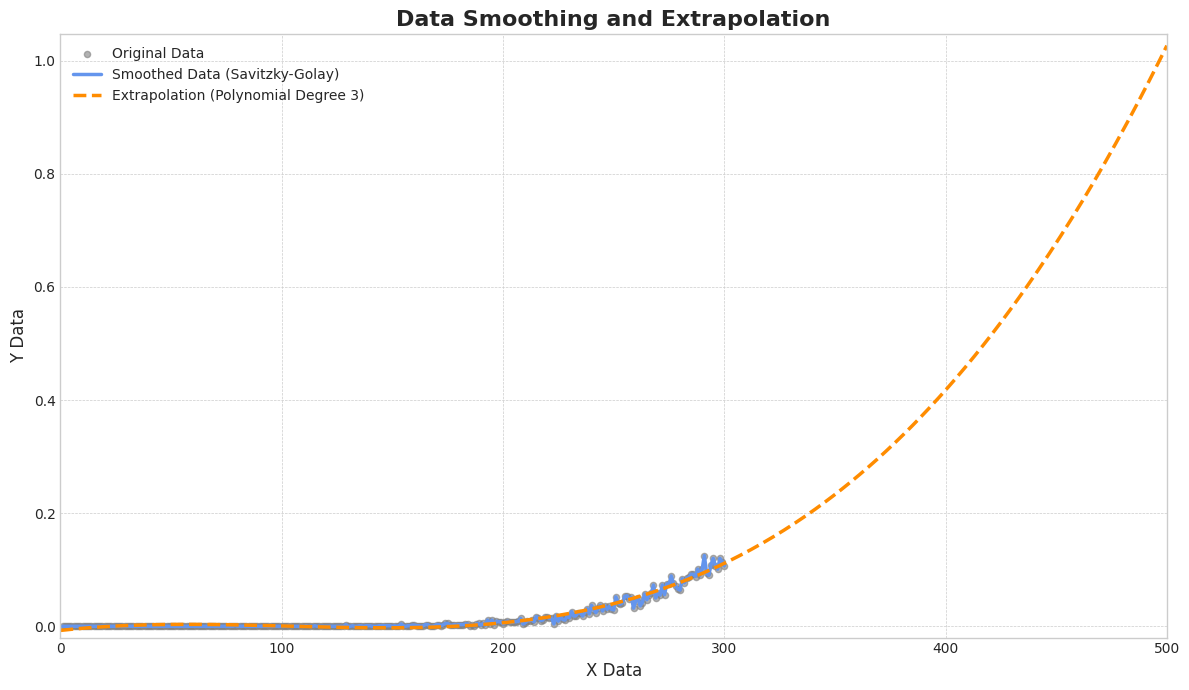

In [10]:
# --- Step 2: Extrapolate the data ---
# We will fit a polynomial to the *smoothed* data to capture the trend.
# A degree of 2 (quadratic) is often a good starting point.
degree = 3
coeffs = np.polyfit(x_data, y_5dp, degree)
poly_func = np.poly1d(coeffs)

# Define the range for extrapolation
# Let's extrapolate out to x = 400
x_extrapolate = np.arange(0, 501)
y_extrapolate = poly_func(x_extrapolate)

# --- Step 3: Plot the results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# Plot original data
ax.scatter(x_data, y_5dp, label='Original Data', color='gray', alpha=0.6, s=20)

# Plot smoothed data
ax.plot(x_data, y_5dp, label=f'Smoothed Data (Savitzky-Golay)', color='cornflowerblue', linewidth=2.5)

# Plot extrapolated data
ax.plot(x_extrapolate, y_extrapolate, label=f'Extrapolation (Polynomial Degree {degree})', color='darkorange', linestyle='--', linewidth=2.5)

# Formatting the plot
ax.set_title('Data Smoothing and Extrapolation', fontsize=16, fontweight='bold')
ax.set_xlabel('X Data', fontsize=12)
ax.set_ylabel('Y Data', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set plot limits for better visualization
ax.set_xlim(left=0, right=500)
ax.set_ylim(bottom=min(y_3dp) - 0.02, top=max(y_extrapolate) + 0.02)

plt.tight_layout()
plt.show()

In [11]:
def find_real(numbers):
    positive_reals = [c.real for c in numbers if c.imag == 0 and c.real > 0]
    return min(positive_reals)

In [12]:
(poly_func_sens-0.9).roots

array([306.28618799+116.00847274j, 306.28618799-116.00847274j,
       100.17838111  +0.j        ])

In [13]:
find_real((poly_func_sens-0.9).roots)

100.17838111348287

In [16]:
mu_sens=find_real((poly_func_sens-0.9).roots)
print(f"sens at {mu_sens:.1f} events number")
print("")
mu_3dp=find_real((poly_func_3dp-0.5).roots)
print(f"3dp at {mu_3dp:.1f} events number")
print("")
mu_5dp=find_real((poly_func_5dp-0.5).roots)
print(f"5dp at {mu_5dp:.1f} events number")
print("")

sens at 100.2 events number

3dp at 229.2 events number

5dp at 417.6 events number



In [25]:
x_1TeV=[0,200,300,500,1000]
y_1TeV=[0,26,60,150,300]
coef = np.polyfit(x_1TeV,y_1TeV,1)
poly1d_100TeV_corr = np.poly1d(coef)

In [26]:
poly1d_100TeV_corr(100.2),poly1d_100TeV_corr(229.2),poly1d_100TeV_corr(417.6)

(12.1944137931035, 53.0740689655173, 112.77737931034491)

In [17]:
# define a function as the spline minus
# the fraction of signal trials above critical TS
def func(mu, spline, perc):
    y = spline.evaluate_simple([mu])
    y = y - perc
    return y

In [18]:
from photospline import (
    SplineTable,
    glam_fit,
    ndsparse,
)

In [19]:
def construct_photospline(n_max, x, y, order=3, smoothing=1, penalty=2):
    """Constructs a penalized B-spline using the photospline package.

    Parameters
    ----------
    n_max: int
        value to construct the range for the spline knots.
    x: sequence of float
        List or array of x values for the spline construction.
    y: sequence of float
        List or array of y values for the spline construction.
    order: int
        Order of the penalized B-spline.
    smoothing: float
        Regularization factor for the penalized B-spline.
    penalty: int
        Penalty factor for the penalized B-spline.

    Returns
    -------
    spline: instance of photospline.SplineTable
    """
    
    knots = np.arange(-0.1,n_max+1, 0.3)
    spline = glam_fit(
        *ndsparse.from_data(
            np.array(y),
            np.ones(np.array(y).shape)),
        [np.array(x)],
        [knots],
        [order] * np.array(x).ndim,
        [smoothing],
        [penalty],
    )

    return spline

In [20]:
from scipy.optimize import root_scalar

In [21]:
# Create interpolation spline for sensitivity and disc potential
spline_sens = construct_photospline(
    n_max, mean_ns_inj, percentage_above_bkg)
spline_3dp = construct_photospline(
    n_max, mean_ns_inj, percentage_above_critical_ts_3dp)

# use scipy to find root
ns_sens = root_scalar(func, args=(spline_sens, 0.9), bracket=[0.1, n_max]).root
print(f'\nMean number of signal events for sensitivity: {ns_sens}')

ns_dp = root_scalar(func, args=(spline_3dp, 0.5), bracket=[0.1, n_max]).root
print(f'Mean number of signal events for 5sigma discovery potential: {ns_dp}')


Mean number of signal events for sensitivity: 102.53905294313944
Mean number of signal events for 5sigma discovery potential: 226.3009342079483


In [22]:
def plot_ax(ax, n_max, x, y, spline, perc, ns_crit):
    """Plots the (x,y) data on a scatter plot and
    the corresponding spline interpolation on the given
    axis `ax`.
    It also indicated the critical percentile value
    and the correspoding mean number of signal events.

    Parameters
    ----------
    ax: instance of matplotlib.axes.Axes
        The figure axis where to plot.
    n_max: int
        Maximum value for the spline x range.
    x: sequence of float
        List or array of x values for the scatter plot.
    y: sequence of float
        List or array of y values for the scatter plot.
    spline: instance of photospline.SplineTable
        The penalized B-spline interpolating y(x).
    perc: float
        The critical percentile
    ns_crit: float
        The mean number of signal events to get the critical percentile.
    """

    spline_xrange = np.linspace(0.1,n_max,100)

    if perc == 0.9:
        data_label = "above bkg median"
    else:
        data_label = "above critical TS"

    ax.scatter(x, y, s=15, c='k', label="% TS "+data_label)
    ax.plot(
        spline_xrange, spline.grideval([spline_xrange]),
        lw=2, ls='--', label="Photospline")
    ax.axhline(perc)
    ax.axvline(ns_crit, ls='--', c='r')

    ax.set_ylabel("p > "+data_label+" [%]", size=12)
    ax.set_xlabel('<$\mu_{inj}$>', size=12)

    ax.legend(frameon=False, prop={'size':10})

    return

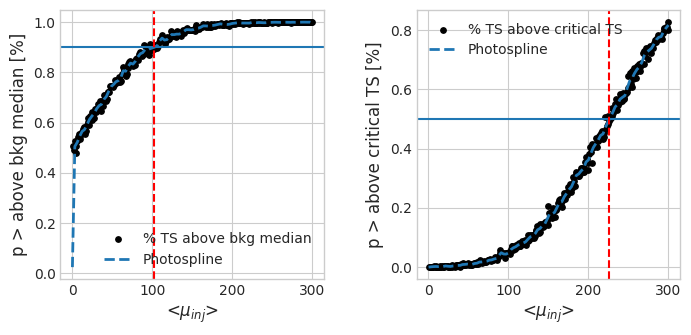

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,3.5))
plot_ax(
    ax1, n_max, mean_ns_inj, percentage_above_bkg, 
    spline_sens, 0.9, ns_sens)
plot_ax(
    ax2, n_max, mean_ns_inj, percentage_above_critical_ts_3dp, 
    spline_3dp, 0.5, ns_dp)

plt.subplots_adjust(wspace=.35)